# Modelo conv2d

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

In [2]:
import os, PIL

# El directorio de trabajo
processDir = './process'

# Directorio para entrenamiento, validacion y test
train_dir = os.path.join(processDir, 'train')
validation_dir = os.path.join(processDir, 'validation')
test_dir = os.path.join(processDir, 'test')


# Modelo

In [3]:
from keras import layers
from keras import models
from keras.applications import InceptionV3
from keras_radam import RAdam

model = models.Sequential()
model.add(InceptionV3(include_top=False, weights='imagenet', input_shape=(200,200,3)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 120)               15480     
Total params: 38,661,656
Trainable params: 38,627,224
Non-trainable params: 34,432
_________________________________________________________________


# Optimizador

In [5]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-7),
              metrics=['categorical_accuracy'])

# Generador de datos

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 200, 200, 3)
labels batch shape: (32, 120)


# Entrenamiento

In [8]:
from keras import callbacks

callbacks = [callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20, restore_best_weights=True, mode='max')]

history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=1000,
      validation_data=validation_generator,
      validation_steps=128, callbacks=callbacks)

Epoch 1/1000
128/128 [==============================] - 104s 814ms/step - loss: 4.8082 - categorical_accuracy: 0.0166 - val_loss: 4.3093 - val_categorical_accuracy: 0.1218
Epoch 2/1000
128/128 [==============================] - 82s 641ms/step - loss: 3.6863 - categorical_accuracy: 0.2061 - val_loss: 2.8817 - val_categorical_accuracy: 0.3556
Epoch 3/1000
128/128 [==============================] - 82s 640ms/step - loss: 3.0993 - categorical_accuracy: 0.2927 - val_loss: 3.6681 - val_categorical_accuracy: 0.2213
Epoch 4/1000
128/128 [==============================] - 82s 641ms/step - loss: 3.0309 - categorical_accuracy: 0.2998 - val_loss: 4.1323 - val_categorical_accuracy: 0.1644
Epoch 5/1000
128/128 [==============================] - 82s 641ms/step - loss: 2.9519 - categorical_accuracy: 0.2900 - val_loss: 3.5182 - val_categorical_accuracy: 0.2318
Epoch 6/1000
128/128 [==============================] - 82s 638ms/step - loss: 2.8083 - categorical_accuracy: 0.3081 - val_loss: 3.2947 - val_ca

Epoch 49/1000
128/128 [==============================] - 82s 640ms/step - loss: 0.7075 - categorical_accuracy: 0.7820 - val_loss: 1.0732 - val_categorical_accuracy: 0.7034
Epoch 50/1000
128/128 [==============================] - 82s 640ms/step - loss: 0.7150 - categorical_accuracy: 0.7788 - val_loss: 1.1003 - val_categorical_accuracy: 0.6986
Epoch 51/1000
128/128 [==============================] - 82s 640ms/step - loss: 0.6817 - categorical_accuracy: 0.7917 - val_loss: 1.0699 - val_categorical_accuracy: 0.7020
Epoch 52/1000
128/128 [==============================] - 82s 637ms/step - loss: 0.7498 - categorical_accuracy: 0.7693 - val_loss: 1.0933 - val_categorical_accuracy: 0.6982
Epoch 53/1000
128/128 [==============================] - 82s 640ms/step - loss: 0.7076 - categorical_accuracy: 0.7788 - val_loss: 1.0954 - val_categorical_accuracy: 0.6993
Epoch 54/1000
128/128 [==============================] - 82s 640ms/step - loss: 0.7004 - categorical_accuracy: 0.7859 - val_loss: 1.0759 - v

# Graficos

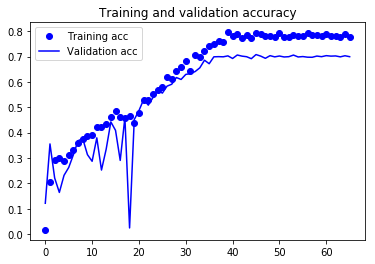

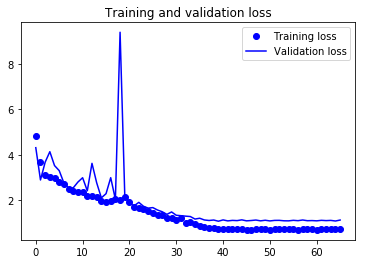

In [11]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model.save('transfer-learning-inception-model.h5')